# SAC 구현

먼저 사용할 모듈들을 불러오자.

In [1]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.distributions import Normal

from rl_learner.networks import network_dict
from rl_learner.buffers import ReplayBuffer
from rl_learner.utils import seed_all

<br>

---

## Double Q-네트워크 구현

### Q-네트워크의 overestimation bias과 double Q-네트워크

SAC는 Q-네트워크를 2개 사용하고 있다. 이는 off-policy 알고리즘에서 흔히 사용되는 기법이다.
뉴럴 네트워크가 편향 (bias)을 갖는 것은 자연스러운 현상이다. 
하지만, Q-네트워크의 경우 네트워크의 출력값을 타겟으로 사용하여 네트워크를 학습시키기 때문에 편향이 더 큰 편향을 발생시킬 수 있다. 

<br>

정책 네트워크 $\pi_{\phi}$가 Q-네트워크 $Q_{\theta}$의 크기를 최대화하는 방향으로 학습된다는 것을 상기시켜보자. 

$$J_{\pi}(\phi)\approx\mathbb{E}_{s_t \sim \mathcal{D}}\left[ \mathbb{E}_{a_t\sim\pi_{\phi}(\cdot|s_t)} \left[\log \pi_{\phi}(a_t | s_t) - Q_{\theta}(s_t, a_t) \right]\right].$$

<br>

위 목적 함수는 손실 함수이기 때문에 $Q_{\theta}(s_t, a_t)$ 값이 크면 클수록 손실 함수 값이 작아진다. 
즉, 위 손실 함수를 최소화하면 $Q_{\theta}(s_t, a_t)$의 값이 큰 행동을 더 많이 취하도록 정책 네트워크가 업데이트된다.
만약 실제 행동 가치 함수 $Q^\pi(s_t, a_t)$보다 $Q_{\theta}(s_t, a_t)$가 과대평가 (overestimation)되어 있으면,
정책 네트워크는 상태 $s_t$에서 행동 $a_t$를 더 많이 선택하도록 업데이트될 것이다. 
업데이트된 정책 네트워크는 환경과 상호 작용할 때 $a_t$를 더 많이 선택하여 데이터를 수집할 것이고, 
그렇다면 또 다시 $(s_t, a_t)$ 근처에 대해서만 네트워크들이 업데이트될 것이다.

<br>

업데이트가 진행될수록 실제 행동 가치 함수에 점점 더 가까워지면서 과대평가가 완화되겠지만, 학습 속도를 저해하는 요인인 것을 확실하다.
우리는 정해진 횟수만큼 환경과 상호작용할 수 있는데, 과대 평가된 행동만 취하며 기회를 날리고 있으니 말이다.
이렇게 실제 가치보다 네트워크가 과대 추정하여 악순환을 만드는 편향을 overestimation bias라고 부른다.
이런 overestimation bias로부터 발생하는 악순환을 막기 위해 많이 사용되는 방법으로 2개의 서로 다른 Q-네트워크를 앙상블하는 방법이 있다.
그 중 TD3라는 연구에서 제안한 double clipped Q-learning은 $(s_t, a_t)$에 대한 행동 가치 함수를 추정할 때, 2개의 Q-네트워크가 출력하는 값 중 작은 값을 선택하는 방식을 사용하는 방식이다. SAC의 구현체에서도 double clipped Q-learning을 사용하게 된다.

<br>

### Double Q-네트워크 및 정책 네트워크 구현

다음은 double Q-네트워크를 구현한 코드이다. 
필자는 DQN 계열 알고리즘에서 등장하는 double Q-네트워크와 이름을 구분하기 위하여 이름을 장황하게 지었는데, 그냥 `DoubleQNetwork`로 사용해도 좋다.
정책 네트워크는 이전과 같다.

In [2]:
class MLPContinuousQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=(256, 256, ), activation_fn=F.relu):
        super(MLPContinuousQNetwork, self).__init__()
        self.input_layer = nn.Linear(state_dim + action_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.activation_fn = activation_fn

    def forward(self, s, a):
        x = torch.cat((s, a), dim=1)
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))
        x = self.output_layer(x)

        return x


class MLPContinuousDoubleQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims, activation_fn):
        super().__init__()
        self.q1 = MLPContinuousQNetwork(state_dim, action_dim, hidden_dims, activation_fn)
        self.q2 = MLPContinuousQNetwork(state_dim, action_dim, hidden_dims, activation_fn)
        
    def forward(self, s, a):
        return self.q1(s, a), self.q2(s, a)


class MLPGaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPGaussianPolicy, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.mu_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.log_std_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))

        mu = self.mu_layer(x)
        log_std = torch.tanh(self.log_std_layer(x))

        return mu, log_std.exp()    

<br>

---

## Replay buffer 구현

Off-policy 알고리즘들은 현재 정책이 수집한 데이터로만 네트워크를 학습시켜야 한다는 가정을 벗어 던졌다. 
따라서 학습 동안에 수집한 데이터 $(s, a, r, s')$을 계속 저장해놓고, 매 스탭마다 batch_size 개수만큼 꺼내서 네트워크들을 업데이트시킨다.
데이터를 저장해놓는 공간을 experience replay memory 또는 replay buffer라고 부른다.
과거에 수집한 경험 (experience)를 가져와서 다시 사용 (replay)한다는 의미에서 붙여진 이름이다.
아래 코드는 데이터를 저장해놓은 replay buffer 클래스를 구현한 것이다.

```{note}
일반적으로 replay buffer의 크기 (최대로 저장할 과거 경험 데이터의 개수)는 벡터 상태 공간의 경우 1,000,000로 설정하고, 이미지 상태 공간의 경우 100,000으로 설정한다. 적은 데이터 개수라고 생각할 수 있지만 다섯 종류의 배열 (`self.s`, `self.a`, `self.r`, `self.s_prime`, `self.done`)을 저장해야 하기 때문에 메모리를 많이 잡아 먹는다. 따라서 각 배열의 `dtype`를 직접 설정해주는 것이 좋다. 특히, 이미지 상태 공간의 경우 반드시 `self.s`와 `self.s_prime`의 `dtype`을 `np.uint8`로 설정해줘야 한다. 심층강화학습에서 주로 사용되는 이미지 크기인 $84\times 84 \times 9$로 메모리를 대충 계산해보면 다음과 같다. (과거 3개의 RGB 이미지를 쌓아서 사용하기 때문에 채널 수가 9이다).

- float32의 사용할 경우, `self.s`만 $100000 \text{개} \times 84 \times 84 \times 9 \times 4 \text{bytes} \approx 23GB$
- np.uint8을 사용할 경우, `self.s`만 $100000 \text{개} \times 84 \times 84 \times 9 \times 1 \text{bytes} \approx 5.9GB$

<br>

`np.uint8`을 사용한다고 해도 `self.s`와 `self.s_prime`의 크기가 $12$GB이다. 10만 개가 아니라 100만 개를 사용할 경우 $120$GB가 된다. 한편, 에피소드 단위로 저장할 경우 `self.s_prime`과 `self.done`을 따로 저장하지 않아도 되기 때문에 메모리를 절약할 수 있다. 이미지 상태 공간, 연속 행공 공간 SOTA 알고리즘인 `DrQ-v2` 논문에서는 효율적인 구조를 사용해서 replay buffer 사이즈를 100만 개까지 늘렸고 꽤 유의미한 성능 향상을 얻을 수 있었다.
```

<br>

In [3]:
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size):
        if np.isscalar(state_dim):
            state_dim = (state_dim, )
        if np.isscalar(action_dim):
            action_dim = (action_dim, )

        self.s = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.a = np.zeros((max_size, *action_dim), dtype=np.float32)
        self.r = np.zeros((max_size, 1), dtype=np.float32)
        self.s_prime = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.done = np.zeros((max_size, 1), dtype=np.uint8)

        self.ptr = 0
        self.size = 0
        self.max_size = max_size

    def __getitem__(self, idx):
        return (
            self.s[idx],
            self.a[idx],
            self.r[idx],
            self.s_prime[idx],
            self.done[idx]
        )

    def sample(self, batch_size):
        idx = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.s[idx]),
            torch.FloatTensor(self.a[idx]),
            torch.FloatTensor(self.r[idx]),
            torch.FloatTensor(self.s_prime[idx]),
            torch.FloatTensor(self.done[idx])
        )

    def store(self, s, a, r, s_prime, done):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s_prime[self.ptr] = s_prime
        self.done[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


<br>

---

## SAC 구현


In [4]:
class SAC:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dims=(1024, 1024),
        activation_fn=F.relu,
        buffer_size=int(1e6),
        min_buffer_size=5000,
        batch_size=256,
        policy_lr=0.0001,
        critic_lr=0.0001,
        gamma=0.99,
        tau=0.005,
        alpha=0.2,
    ):
        self.action_dim = action_dim
        self.tau = tau
        self.alpha = alpha
        self.gamma = gamma
        self.min_buffer_size = min_buffer_size
        self.batch_size = batch_size

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy = MLPGaussianPolicy(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.critic = MLPContinuousDoubleQNetwork(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.target_critic = MLPContinuousDoubleQNetwork(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=policy_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.t = 0
        self.buffer = ReplayBuffer(state_dim, action_dim, buffer_size)

    @torch.no_grad()
    def act(self, s, training=True):
        if (self.buffer.size < self.min_buffer_size) and training:
            return np.random.rand(self.action_dim)
        self.policy.train(training)

        s = torch.as_tensor(s, dtype=torch.float, device=self.device)
        mu, std = self.policy(s)
        z = torch.normal(mu, std) if training else mu
        action = torch.tanh(z)

        return action.cpu().numpy()

    def sample_action(self, state):
        mu, std = self.policy(state)
        m = Normal(mu, std)
        z = m.rsample()
        a = torch.tanh(z)

        log_prob = m.log_prob(z)
        log_prob -= torch.log(1. - a.pow(2) + 1e-7)
        log_prob = log_prob.sum(1, keepdim=True)

        return a, log_prob

    def learn(self):
        self.policy.train()
        self.critic.train()
        
        s, a, r, s_prime, done = self.buffer.sample(self.batch_size)
        s, a, r, s_prime, done = map(lambda x: x.to(self.device), [s, a, r, s_prime, done])

        # Sample a next action to compute the td target for updating the critic
        with torch.no_grad():
            a_prime, log_prob_prime = self.sample_action(s_prime)
            next_q1, next_q2 = self.target_critic(s_prime, a_prime)
            next_q = torch.min(next_q1, next_q2)
            td_target = r + (1. - done) * self.gamma * (next_q - self.alpha * log_prob_prime)

        # Update the critic network
        q1, q2 = self.critic(s, a)
        critic_loss = F.mse_loss(q1, td_target) + F.mse_loss(q2, td_target)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Sample a current action for the policy gradient
        a_sampled, log_prob = self.sample_action(s)
        policy_q1, policy_q2 = self.critic(s, a_sampled)
        policy_q = torch.min(policy_q1, policy_q2)

        policy_loss = -(policy_q - self.alpha * log_prob).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        
        result = {'Step': self.t, 'policy_loss': policy_loss.item(), 'value_loss': critic_loss.item()}
        
        return result

    def step(self, transition):
        result = None
        self.t += 1
        self.buffer.store(*transition)
        if self.buffer.size >= self.min_buffer_size:
            result = self.learn()
            for t_p, p in zip(self.target_critic.parameters(), self.critic.parameters()):
                t_p.data.copy_(self.tau * p.data + (1 - self.tau) * t_p.data)

        return result
    

<br>

### HalfCheetah-v4 환경 제어

제목이 곧 내용이다! 

In [5]:
def evaluate(env_name, agent, seed, eval_iterations):
    env = gym.make(env_name)
    scores = []
    for i in range(eval_iterations):
        (s, _), terminated, truncated, score = env.reset(seed=seed + 100 + i), False, False, 0
        while not (terminated or truncated):
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, _ = env.step(a)
            score += r
            s = s_prime
        scores.append(score)
    env.close()
    return round(np.mean(scores), 4)

In [6]:
def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [7]:
env_name = 'HalfCheetah-v4'

seed = 0
seed_all(seed)
hidden_dims = (256, 256, )
max_iterations = 1000000
eval_intervals = 10000
eval_iterations = 10

buffer_size = int(1e6)
min_buffer_size = 5000
batch_size = 256
gamma = 0.99

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = SAC(
    state_dim,
    action_dim,
    hidden_dims=hidden_dims,
    buffer_size=buffer_size,
    min_buffer_size=min_buffer_size,
    batch_size=batch_size,
    gamma=gamma,
)

logger = []
(s, _), terminated, truncated = env.reset(seed=seed), False, False
for t in tqdm(range(1, max_iterations + 1)):
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(a)
    result = agent.step((s, a, r, s_prime, terminated))
    s = s_prime
    
    if result is not None:
        logger.append([t, 'policy_loss', result['policy_loss']])
        logger.append([t, 'value_loss', result['value_loss']])
    
    if terminated or truncated:
        (s, _), terminated, truncated = env.reset(), False, False
        
    if t % eval_intervals == 0:
        score = evaluate(env_name, agent, seed, eval_iterations)
        logger.append([t, 'Avg return', score])

100%|██████████| 1000000/1000000 [1:53:40<00:00, 146.62it/s] 


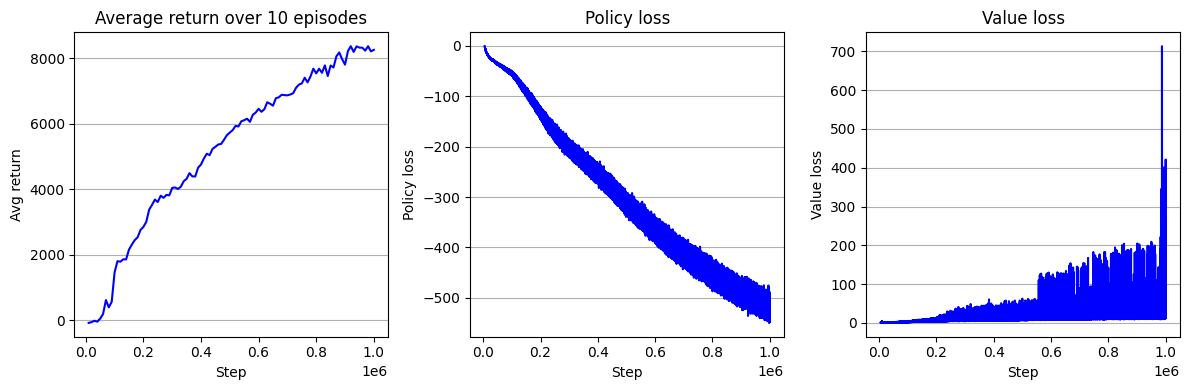

In [8]:
logger = pd.DataFrame(logger)
logger.columns = ['step', 'key', 'value']

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 3, 1)
key = 'Avg return'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Average return over 10 episodes")
ax.set_xlabel("Step")
ax.set_ylabel("Avg return")

ax = fig.add_subplot(1, 3, 2)
key = 'policy_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Policy loss")
ax.set_xlabel("Step")
ax.set_ylabel("Policy loss")

ax = fig.add_subplot(1, 3, 3)
key = 'value_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Value loss")
ax.set_xlabel("Step")
ax.set_ylabel("Value loss")

fig.tight_layout()
plt.show()

<br>

```{raw} html
<script
   type="text/javascript"
   src="https://utteranc.es/client.js"
   async="async"
   repo="HiddenBeginner/Deep-Reinforcement-Learnings"
   issue-term="pathname"
   theme="github-light"
   label="💬 comment"
   crossorigin="anonymous"
/>
```
